# CS Bank Data – Case Study (Data Analyst / Engineer)

This notebook documents my end-to-end work on a messy “CS bank data” CSV export provided from a core banking system.

## 1) Assignment (what I was asked to deliver)

I received a single CSV file and a separate “dataset description” explaining the meaning of each column.  
The file is not analysis-ready and contains quality issues (missing values, inconsistent formatting, mixed entities in one table).

The requested deliverables were:

1. **Adjust / clean the raw CSV** so it can be reliably processed.
2. **Divide the dataset into separate entities** (normalized tables).
3. **Create a logical model** of the entities including **primary keys (PK)** and **foreign keys (FK)**.
4. Produce business outputs:
   - **(a)** overview of available banking products and their current volume
   - **(b)** count and volume of transactions per product (noting that some transactions may be inconsistent)
   - **bonus:** costs and revenues per product in the last year (**2023**) and product profitability
     - consider **interest rates** (Loans = interest revenue, Savings = interest cost)
     - consider **transaction fees** (Current + Savings = fee revenue)
5. Ensure every finding is supported by **code, data, or clearly stated assumptions**, ready for presentation.

## 2) What I prepared (step-by-step approach)

### Step 0 — Setup
- Imported Python libraries used in the analysis (`pandas`, `numpy`, `plotly`).
- Configured display options for easier inspection.

### Step 1 — Robust ingestion of the raw CSV
Because the file was messy, I used a “robust loader” approach:
- handled potential encoding problems (non-UTF8 issues)
- detected delimiter (comma/semicolon/tab) rather than assuming one
- loaded all columns as strings first to avoid parsing failures
- performed basic sanity checks (shape, column list, preview)

**Outcome:** a raw dataframe that loads consistently without crashing, even with broken rows.

### Step 2 — Basic profiling and data-quality fixes
I profiled the raw columns and applied pragmatic standardization:
- trimmed whitespace for string fields
- normalized missing values (empty strings, “NA”, “NULL”, etc.)
- converted key numeric fields safely:
  - balances split into numeric amount + currency
  - transaction amounts converted to numeric (including decimal comma handling)
  - APR converted from scientific notation into standard decimal numbers
- normalized phone numbers to a consistent format (removed punctuation, optional prefix normalization)

**Outcome:** a clean base dataset suitable for entity extraction and joins.

### Step 3 — Entity splitting (normalization)
The raw file contained multiple entity types mixed into one table.  
I split it into normalized entity tables:

- **Customers**
- **Accounts**
- **Branches**
- **Employees**
- **Transactions**

For each entity I:
- selected relevant columns
- removed duplicates (where applicable)
- ensured stable datatypes and consistent formats
- preserved identifiers needed for relationships

**Outcome:** five normalized tables that can be exported and used downstream (analytics / BI / database load).

### Step 4 — Logical model (PK/FK relationships)
I defined and validated the logical model:

- **Customers**
  - PK: `CustomerID`
- **Accounts**
  - PK: `AccountID`
  - FK: `CustomerID` → Customers
  - FK: `BranchID` → Branches
- **Transactions**
  - PK: `TransactionID`
  - FK: `AccountID` → Accounts
- **Branches**
  - PK: `BranchID`
  - FK: `ManagerID` → Employees (manager is an employee)
- **Employees**
  - PK: `EmployeeID`
  - FK: `BranchID` → Branches

I also checked joinability (e.g., whether AccountIDs in transactions exist in accounts).

**Outcome:** an explainable relational structure, consistent with how core banking data is typically modeled.

### Step 5 — Business output (a): products and current volume
Interpretation:
- **Product** = `AccountType` (Current / Saving / Loan)
- **Current volume** = portfolio size based on account balances

Because balances exist in multiple currencies (CZK/EUR), I reported volume **separately per currency** (no FX rates provided).

Outputs:
- number of accounts per product
- total / average / min / max balance per product
- portfolio shares within currency
- supporting Plotly charts

### Step 6 — Business output (b): transaction count and volume per product (with inconsistencies)
Link:
`transactions.AccountID → accounts.AccountID → accounts.AccountType`

Volume definitions:
- **Gross volume** = `sum(abs(Amount))`
- **Net volume** = `sum(Amount)`

Inconsistency handling:
- I applied a transparent sanity rule: **Fee > abs(Amount)** as suspicious.
- I reported results for:
  - **all transactions**
  - **clean transactions** (excluding flagged rows)
- I also summarized how many rows were flagged and what share of the dataset they represent.

### Step 7 — Bonus: 2023 costs, revenues, and profitability per product
Goal:
Estimate a simple product P&L for **2023**, per currency.

Approach (documented assumptions due to limited data):
- **Interest approximation:** `Balance × APR × active_fraction_in_2023`
  - balance treated as a proxy for average balance (no daily balance history)
  - if `DateOpened` is available, pro-rate activity within 2023
- **Fee revenue:** sum of transaction `Fee` in 2023 for Current + Saving
- excluded inconsistent fees from “clean fee revenue”
- reported profitability KPIs:
  - profit margin
  - profit on balance
  - profit per account

Outputs:
- P&L table per product/currency
- flagged-fee audit trail for 2023
- Plotly charts for profit and component breakdown

## 3) Important note on currencies
The dataset includes **CZK and EUR**.  
I do **not** mix currencies in totals and profitability unless FX conversion rules/rates are provided.

## 4) Exported deliverables
At the end, I export the cleaned entity tables and key output tables (product overview, transaction metrics, 2023 P&L) to a local folder so the results can be reused outside the notebook.


#### Imports + display options

In [1]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

## 1) Loading the raw file (robust approach)

The file is not clean:
- encoding can be non-UTF8,
- delimiter can vary,
- there can be junk rows before the real header.

So I:
- inspect the binary header (to detect non-CSV files),
- try multiple encodings,
- locate the header line by searching for `CustomerID` and `AccountID`,
- pick delimiter from the header line,
- read with `skiprows` so pandas starts at the real header.


#### Loader code

In [2]:
csv_path = Path("CS bank data.csv")   

def pick_delim_from_header_line(line: str) -> str:
    candidates = [",", ";", "\t", "|"]
    counts = {d: line.count(d) for d in candidates}
    best = max(counts, key=counts.get)
    return best

def robust_load_csv(path: Path, max_lines_scan=300):
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path.resolve()}")

    head = path.read_bytes()[:5000]
    if head[:2] == b"PK":
        raise ValueError("This looks like an .xlsx (zip). Use pd.read_excel(...) instead of read_csv.")
    if head[:8] == b"\xD0\xCF\x11\xE0\xA1\xB1\x1A\xE1":
        raise ValueError("This looks like an old .xls file. Use pd.read_excel(...) instead of read_csv.")

    encodings_to_try = ["utf-8", "utf-8-sig", "cp1250", "cp1252", "latin1", "utf-16", "utf-16le"]

    for enc in encodings_to_try:
        try:
            with open(path, "r", encoding=enc, errors="replace") as f:
                sample_lines = []
                for _ in range(max_lines_scan):
                    line = f.readline()
                    if not line:
                        break
                    sample_lines.append(line)

            header_idx = None
            header_line = None
            for i, line in enumerate(sample_lines):
                if "CustomerID" in line and "AccountID" in line:
                    header_idx = i
                    header_line = line
                    break

            if header_idx is None:
                continue

            delim = pick_delim_from_header_line(header_line)

            df = pd.read_csv(
                path,
                sep=delim,
                encoding=enc,
                dtype=str,
                engine="python",
                keep_default_na=True,
                na_values=["", " ", "NA", "N/A", "null", "NULL", "None"],
                skiprows=header_idx,
                header=0,
                on_bad_lines="skip"
            )

            # minimal validation
            required = {"CustomerID", "AccountID", "TransactionID"}
            if not required.issubset(set(df.columns)):
                continue

            return df, enc, delim, header_idx

        except Exception:
            continue

    raise ValueError("Could not load: header line with CustomerID/AccountID not found with tested encodings.")

raw, used_enc, used_sep, skiprows_n = robust_load_csv(csv_path)

print("LOADED OK")
print("Encoding :", used_enc)
print("Delimiter:", repr(used_sep))
print("Skiprows :", skiprows_n)
print("Raw shape:", raw.shape)
print("Columns  :", list(raw.columns))
display(raw.head(10))


LOADED OK
Encoding : utf-16
Delimiter: ','
Skiprows : 0
Raw shape: (3398, 24)
Columns  : [' ', 'CustomerID', 'Name', 'Address', 'Phone', 'Phone_2', 'Email', 'DateJoined', 'AccountID', 'BranchID', 'AccountType', 'DateOpened', 'Balance', 'APR', 'TransactionID', 'Date', 'Type', 'Amount', 'Fee', 'BranchName', 'ManagerID', 'EmployeeID', 'Position', 'DateHired']


,,CustomerID,Name,Address,Phone,Phone_2,Email,DateJoined,AccountID,BranchID,AccountType,DateOpened,Balance,APR,TransactionID,Date,Type,Amount,Fee,BranchName,ManagerID,EmployeeID,Position,DateHired
0,0,1.0,Allison Hill,"819 Johnson Course,East William, AK 74064",886.737.9402,223-951-1615x594,dudleynicholas@example.net,2013-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2.0,Lisa Hensley,"34131 Ramirez Roads,Franciscostad, IL 88342",719-228-3276x483,505.964.1395,pwilkerson@example.com,2008-10-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3.0,David Hoffman,"653 William Course Apt. 122,Carlsonfurt, MS 78605",484.980.1845x146,5484281489,kathryn88@example.org,2014-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,4.0,Brian Cox DVM,"39117 Tiffany Place,East Donna, OH 22144",989-363-8346x578,531.250.9839,zimmermanbrian@example.org,2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5.0,Andrea Young,"299 Sanchez Mountains,Leeville, TN 56999",(566)970-1065x133,(362)247-3178,novaksara@example.org,2009-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,6.0,John Hancock,"PSC 2606, Box 4746,APO AP 96249",+1-272-734-3098,3094788208,larsonemma@example.org,2017-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,7.0,Steve Sanchez,"9985 Harris Stravenue,Johnfurt, DC 88540",+1-647-451-0799x1183,NaN,nicole35@example.com,2009-04-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,8.0,Joshua Turner,"Unit 8084 Box 1241,DPO AE 97811",+1-924-649-3534,4169400524,hhoffman@example.org,2009-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,9.0,Sandra Aguilar,"45053 Elizabeth Knoll,Dicksonberg, IA 21800",(360)825-6342,2735375433,emurphy@example.com,2015-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,10.0,Jennifer Zavala,"42940 Candace Key,Samuelhaven, DE 50989",001-734-806-0883,759-851-4846,angela36@example.net,2016-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2) Quick profiling (what is inside?)

Before any transformations I quickly check:
- missingness,
- basic unique counts for key columns,
- obvious issues (mixed formats, partial rows).


#### Quick profiling code

In [3]:
df0 = raw.copy()

# rename first column if it is an unnamed index-like column
first_col = df0.columns[0]
if str(first_col).lower().startswith("unnamed") or str(first_col).strip() == "":
    df0 = df0.rename(columns={first_col: "RowNo"})
else:
    df0 = df0.rename(columns={first_col: "RowNo"})

# strip strings
for c in df0.columns:
    df0[c] = df0[c].astype("string").str.strip()

print("Missingness (top 12 cols by missing %):")
miss = (df0.isna().mean() * 100).sort_values(ascending=False).head(12).round(2)
display(miss)

print("Key columns quick unique counts:")
for c in ["CustomerID", "AccountID", "TransactionID", "BranchID", "EmployeeID"]:
    if c in df0.columns:
        print(f"{c:14s} uniques =", df0[c].nunique(dropna=True))

Missingness (top 12 cols by missing %):


ManagerID     99.76
BranchName    99.76
DateHired     98.12
Position      98.12
EmployeeID    98.12
Phone_2       97.65
DateJoined    97.06
Address       96.82
Phone         95.67
DateOpened    95.59
APR           95.59
Balance       95.59
dtype: float64

Key columns quick unique counts:
CustomerID     uniques = 100
AccountID      uniques = 150
TransactionID  uniques = 3076
BranchID       uniques = 8
EmployeeID     uniques = 64


## 3) Build clean entities (normalization)

I split the raw dataset into 5 entities:
- `customers`
- `branches`
- `employees`
- `accounts`
- `transactions`

**Cleaning rules implemented:**
- phones: remove `. ( ) - spaces`, `+` becomes `00`
- balances: split `Balance` into `BalanceAmount` (float) and `BalanceCurrency` (CZK/EUR)
- APR: convert scientific strings like `5,0000000000000003E-2` to float (0.05)
- Amount/Fee: numeric conversion with decimal comma support (`2777,469` → `2777.469`)


#### Entity build code

In [4]:
df = df0.copy()
df = df.replace({"": pd.NA, "NA": pd.NA, "N/A": pd.NA, "null": pd.NA, "NULL": pd.NA, "None": pd.NA})

def first_non_null(s: pd.Series):
    s = s.dropna()
    return s.iloc[0] if len(s) else pd.NA

def clean_date(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, errors="coerce")

def clean_number(s: pd.Series) -> pd.Series:
    s = s.astype("string")
    s = s.str.replace(r"[^\d,\.\-]", "", regex=True)

    # both comma + dot -> comma as thousands separator
    s = s.apply(lambda x: x.replace(",", "") if isinstance(x, str) and ("," in x and "." in x) else x)
    # only comma -> comma as decimal separator
    s = s.apply(lambda x: x.replace(",", ".") if isinstance(x, str) and ("," in x and "." not in x) else x)

    return pd.to_numeric(s, errors="coerce")

def clean_apr(s: pd.Series) -> pd.Series:
    s = s.astype("string").str.strip()
    s = s.str.replace(",", ".", regex=False)
    s = s.str.replace(r"\s+", "", regex=True)
    s = s.str.replace("%", "", regex=False)
    return pd.to_numeric(s, errors="coerce")

def split_money_and_currency(s: pd.Series):
    txt = s.astype("string").str.upper()
    currency = txt.str.extract(r"\b(EUR|CZK)\b", expand=False)
    amount_txt = txt.str.replace(r"\b(EUR|CZK)\b", "", regex=True)
    amount = clean_number(amount_txt)
    return amount, currency

def normalize_phone_value(x):
    if pd.isna(x):
        return pd.NA
    s = str(x).strip()
    if not s:
        return pd.NA
    s = re.sub(r"(ext\.?|extension|x)\s*\d+\s*$", "", s, flags=re.I).strip()
    if s.startswith("+"):
        s = "00" + s[1:]
    s = re.sub(r"[^\d]", "", s)
    return s if s else pd.NA

def normalize_phone_series(s: pd.Series) -> pd.Series:
    return s.apply(normalize_phone_value)

def has(colname: str) -> pd.Series:
    if colname not in df.columns:
        return pd.Series([False] * len(df), index=df.index)
    return df[colname].notna()

# row classification (no hard-coded coordinates)
has_customer = has("CustomerID")
has_account  = has("AccountID")
has_tx       = has("TransactionID")
has_branchid = has("BranchID")
has_branchnm = has("BranchName")
has_emp      = has("EmployeeID")

is_customer_row = has_customer & (~has_account) & (~has_tx)
is_account_row  = has_account & (~has_tx)
is_tx_row       = has_tx
is_branch_row   = has_branchid & has_branchnm
is_employee_row = has_emp

print("Row classification counts:")
print("customer rows :", int(is_customer_row.sum()))
print("account rows  :", int(is_account_row.sum()))
print("tx rows       :", int(is_tx_row.sum()))
print("branch rows   :", int(is_branch_row.sum()))
print("employee rows :", int(is_employee_row.sum()))


Row classification counts:
customer rows : 100
account rows  : 150
tx rows       : 3076
branch rows   : 8
employee rows : 64


In [5]:
# ----------------------------
# CUSTOMERS
# ----------------------------
customer_cols = [c for c in ["CustomerID","Name","Address","Phone","Phone_2","Email","DateJoined"] if c in df.columns]
customers_raw = df.loc[is_customer_row, customer_cols].copy()

if len(customers_raw):
    customers = (
        customers_raw.groupby("CustomerID", as_index=False)
        .agg({c: first_non_null for c in customers_raw.columns if c != "CustomerID"})
    )
    if "DateJoined" in customers.columns:
        customers["DateJoined"] = clean_date(customers["DateJoined"]).dt.date
    if "Phone" in customers.columns:
        customers["Phone"] = normalize_phone_series(customers["Phone"])
    if "Phone_2" in customers.columns:
        customers["Phone_2"] = normalize_phone_series(customers["Phone_2"])
else:
    customers = pd.DataFrame(columns=customer_cols)

print("\ncustomers:", customers.shape)
display(customers.head(10))


customers: (100, 7)


,CustomerID,Name,Address,Phone,Phone_2,Email,DateJoined
0,1.0,Allison Hill,"819 Johnson Course,East William, AK 74064",8867379402,2239511615,dudleynicholas@example.net,2013-11-30
1,10.0,Jennifer Zavala,"42940 Candace Key,Samuelhaven, DE 50989",0017348060883,7598514846,angela36@example.net,2016-11-01
2,100.0,Phillip Macias,"9849 Sonya Viaduct Apt. 770,Port Diane, AS 68416",8622110225,<NA>,scastillo@example.com,2023-11-18
3,11.0,Stephanie Gilbert,"4369 Marshall Mills,New Thomas, MH 96964",5145895134,5008379176,jross@example.net,2004-02-15
4,12.0,Shannon Mcclure,"87083 Stephen Unions,Contrerasside, PA 42089",0019795868727,5718434558,jasminebrown@example.com,2015-03-12
5,13.0,Jennifer Clark,"670 Evans Loaf,Medinaside, AS 79570",8734467065,9294806990,greenmark@example.com,2015-01-20
6,14.0,Shawn Ramirez,"USCGC King,FPO AE 62145",5802531003,0013234271937,daniel04@example.net,2016-09-14
7,15.0,Miguel Jones,"49190 Patel Shore,Caseymouth, AL 55558",9168572628,0017942531473,lrosales@example.com,2011-02-24
8,16.0,David Ramirez,"083 John Lodge Suite 837,Westtown, CO 39067",7638495788,0014855574443,joannahill@example.net,2021-10-12
9,17.0,Veronica Wall,"40824 Terri Plaza Suite 271,New Justinfort, NV...",2044711671,5948131869,tkerr@example.net,2018-07-09


In [6]:
# ----------------------------
# BRANCHES (include Address -> BranchAddress)
# ----------------------------
branch_cols = [c for c in ["BranchID","BranchName","ManagerID","Address"] if c in df.columns]
branches_raw = df.loc[is_branch_row, branch_cols].copy()
if "Address" in branches_raw.columns:
    branches_raw = branches_raw.rename(columns={"Address": "BranchAddress"})

if len(branches_raw):
    branches = (
        branches_raw.groupby("BranchID", as_index=False)
        .agg({c: first_non_null for c in branches_raw.columns if c != "BranchID"})
    )
else:
    branches = pd.DataFrame(columns=list(branches_raw.columns) if len(branch_cols) else ["BranchID"])

print("\nbranches:", branches.shape)
display(branches.head(10))


branches: (8, 4)


,BranchID,BranchName,ManagerID,BranchAddress
0,1.0,Holmes Ltd,2.0,"489 Bailey Via,Jeremyborough, NH 53448"
1,2.0,"Smith, Thompson and Hunter",15.0,"1848 Benson Lane Suite 357,Mosleytown, NJ 15740"
2,3.0,Jones-Schultz,35.0,"Unit 3565 Box 8804,DPO AE 38156"
3,4.0,Ross Ltd,44.0,"275 Robinson Ports,Ianborough, NM 97115"
4,5.0,Young and Sons,15.0,"33952 David Common,Austinside, AZ 63715"
5,6.0,Oliver-Vasquez,38.0,"Unit 9472 Box 8463,DPO AP 17310"
6,7.0,Fox Group,56.0,"562 Bray Square,Stewarttown, AL 88857"
7,8.0,Gray Inc,21.0,"84347 Diaz Parks Suite 365,Melissaview, NV 24079"


In [7]:
# ----------------------------
# EMPLOYEES
# ----------------------------
employee_cols = [c for c in ["EmployeeID","BranchID","Position","DateHired","Name","Phone","Email"] if c in df.columns]
employees_raw = df.loc[is_employee_row, employee_cols].copy()
employees_raw = employees_raw.rename(columns={"Name":"EmployeeName","Phone":"EmployeePhone","Email":"EmployeeEmail"})

if len(employees_raw):
    employees = (
        employees_raw.groupby("EmployeeID", as_index=False)
        .agg({c: first_non_null for c in employees_raw.columns if c != "EmployeeID"})
    )
    if "DateHired" in employees.columns:
        employees["DateHired"] = clean_date(employees["DateHired"]).dt.date
    if "EmployeePhone" in employees.columns:
        employees["EmployeePhone"] = normalize_phone_series(employees["EmployeePhone"])
else:
    employees = pd.DataFrame(columns=list(employees_raw.columns) if len(employee_cols) else ["EmployeeID"])

print("\nemployees:", employees.shape)
display(employees.head(10))


employees: (64, 7)


,EmployeeID,BranchID,Position,DateHired,EmployeeName,EmployeePhone,EmployeeEmail
0,1.0,8.0,Loan Officer,2023-10-24,Jodi Young,3464692548,phillipsapril@example.org
1,10.0,5.0,Teller,2010-10-21,Kenneth Collins,<NA>,waynecohen@example.com
2,11.0,2.0,Security,2015-02-18,Charles Brown,<NA>,pjacobs@example.net
3,12.0,3.0,Teller,2019-07-09,Sherry Stevens,0014018475469,haydenwilliamson@example.com
4,13.0,5.0,Loan Officer,2016-06-27,Matthew Hale,5609324841,jriddle@example.org
5,14.0,2.0,Security,2008-08-02,Brian Miranda,8675243807,qjohnson@example.org
6,15.0,2.0,Security,2017-03-29,Paul Washington,4182372742,thompsondavid@example.net
7,16.0,8.0,Loan Officer,2005-02-11,Michael Smith,<NA>,eric52@example.org
8,17.0,8.0,Teller,2010-09-30,Kim Ramos,2818647090,sarahbrooks@example.org
9,18.0,6.0,Loan Officer,2009-08-27,Javier Hays,<NA>,lori13@example.org


In [8]:
# ----------------------------
# ACCOUNTS (Balance split + APR)
# ----------------------------
account_cols = [c for c in ["AccountID","CustomerID","BranchID","AccountType","DateOpened","Balance","APR"] if c in df.columns]
accounts_raw = df.loc[is_account_row, account_cols].copy()

if len(accounts_raw):
    accounts = (
        accounts_raw.groupby("AccountID", as_index=False)
        .agg({c: first_non_null for c in accounts_raw.columns if c != "AccountID"})
    )

    if "DateOpened" in accounts.columns:
        accounts["DateOpened"] = clean_date(accounts["DateOpened"]).dt.date

    if "Balance" in accounts.columns:
        bal_amount, bal_curr = split_money_and_currency(accounts["Balance"])
        accounts["BalanceAmount"] = bal_amount
        accounts["BalanceCurrency"] = bal_curr
        # keep a numeric Balance too
        accounts["Balance"] = accounts["BalanceAmount"]

    if "APR" in accounts.columns:
        accounts["APR"] = clean_apr(accounts["APR"])
else:
    accounts = pd.DataFrame(columns=account_cols)

print("\naccounts:", accounts.shape)
display(accounts.head(10))


accounts: (150, 9)


,AccountID,CustomerID,BranchID,AccountType,DateOpened,Balance,APR,BalanceAmount,BalanceCurrency
0,1.0,93.0,5.0,Saving,2023-05-21,12981.20000,0.05,12981.20000,CZK
1,10.0,17.0,2.0,Current,2016-11-25,76583.40000,0.0,76583.40000,CZK
2,100.0,4.0,2.0,Saving,2006-02-10,898563.00000,0.02,898563.00000,CZK
3,101.0,99.0,8.0,Loan,2020-01-16,306053.00000,0.08,306053.00000,EUR
4,102.0,74.0,7.0,Loan,2022-08-08,569270.00000,0.11,569270.00000,EUR
5,103.0,52.0,3.0,Loan,2005-10-09,897932.00000,0.08,897932.00000,EUR
6,104.0,97.0,3.0,Loan,2004-11-02,184464.00000,0.1,184464.00000,EUR
7,105.0,90.0,5.0,Loan,2017-06-13,973025.00000,0.07,973025.00000,EUR
8,106.0,72.0,1.0,Current,2021-10-08,46455.00000,0.0,46455.00000,CZK
9,107.0,18.0,7.0,Loan,2006-10-10,1.14684,0.06,1.14684,EUR


In [9]:
# ----------------------------
# TRANSACTIONS (Amount/Fee numeric, Date timestamp)
# ----------------------------
tx_cols = [c for c in ["TransactionID","AccountID","Date","Type","Amount","Fee"] if c in df.columns]
tx_raw = df.loc[is_tx_row, tx_cols].copy()

if len(tx_raw):
    transactions = (
        tx_raw.groupby("TransactionID", as_index=False)
        .agg({c: first_non_null for c in tx_raw.columns if c != "TransactionID"})
    )

    if "Date" in transactions.columns:
        transactions["Date"] = clean_date(transactions["Date"])

    if "Amount" in transactions.columns:
        transactions["Amount"] = clean_number(transactions["Amount"])

    if "Fee" in transactions.columns:
        transactions["Fee"] = clean_number(transactions["Fee"])
else:
    transactions = pd.DataFrame(columns=tx_cols)

print("\ntransactions:", transactions.shape)
display(transactions.head(10))


transactions: (3076, 6)


,TransactionID,AccountID,Date,Type,Amount,Fee
0,1,46.0,2000-01-02 03:32:38,Deposit,1570.02,50
1,10,2.0,2000-01-25 07:05:26,Deposit,2845.12,50
2,100,54.0,2000-11-04 06:06:24,Withdrawal,1562.21,100
3,1000,90.0,2008-01-07 10:04:18,Deposit,1389.11,50
4,1001,110.0,2008-01-12 10:01:00,Transfer,1406.55,0
5,1002,141.0,2008-01-13 02:46:10,Transfer,995.53,0
6,1003,146.0,2008-01-14 08:09:58,Deposit,1201.22,5
7,1004,59.0,2008-01-14 10:48:50,Withdrawal,1713.67,100
8,1005,92.0,2008-01-16 15:38:47,Deposit,2420.75,50
9,1006,148.0,2008-01-18 00:13:21,Withdrawal,1135.98,100


## 4) Logical model (PK/FK)

**Customers**
- PK: `CustomerID`

**Branches**
- PK: `BranchID`
- FK: `ManagerID` → `employees.EmployeeID` (optional)

**Employees**
- PK: `EmployeeID`
- FK: `BranchID` → `branches.BranchID`

**Accounts**
- PK: `AccountID`
- FK: `CustomerID` → `customers.CustomerID`
- FK: `BranchID` → `branches.BranchID`

**Transactions**
- PK: `TransactionID`
- FK: `AccountID` → `accounts.AccountID`

I validate PK uniqueness + basic FK referential integrity below.


#### 9) PK/FK validation

In [10]:
MODEL = {
    "customers": {"pk": ["CustomerID"], "fks": {}},
    "branches":  {"pk": ["BranchID"], "fks": {"ManagerID": ("employees", "EmployeeID")}},  # optional
    "employees": {"pk": ["EmployeeID"], "fks": {"BranchID": ("branches", "BranchID")}},
    "accounts":  {"pk": ["AccountID"], "fks": {"CustomerID": ("customers", "CustomerID"),
                                               "BranchID": ("branches", "BranchID")}},
    "transactions": {"pk": ["TransactionID"], "fks": {"AccountID": ("accounts", "AccountID")}},
}

TABLES = {
    "customers": customers,
    "branches": branches,
    "employees": employees,
    "accounts": accounts,
    "transactions": transactions
}

def check_pk(df: pd.DataFrame, pk_cols: list[str], table_name: str):
    pk = df[pk_cols]
    null_rows = pk.isna().any(axis=1).sum()
    dup_rows = pk.dropna().duplicated().sum()
    print(f"[PK] {table_name}: null rows={int(null_rows)}, duplicate PK rows={int(dup_rows)}")

def check_fk(child: pd.DataFrame, parent: pd.DataFrame, child_col: str, parent_col: str,
             child_name: str, parent_name: str, optional=False):
    if child_col not in child.columns or parent_col not in parent.columns:
        print(f"[FK] {child_name}.{child_col} -> {parent_name}.{parent_col}: missing columns")
        return
    child_vals = set(child[child_col].dropna().unique())
    parent_vals = set(parent[parent_col].dropna().unique())
    missing = child_vals - parent_vals
    print(f"[FK] {child_name}.{child_col} -> {parent_name}.{parent_col}: missing refs={len(missing)}" + (" (optional)" if optional else ""))

print("=== PK checks ===")
for tname, spec in MODEL.items():
    check_pk(TABLES[tname], spec["pk"], tname)

print("\n=== FK checks ===")
for child_name, spec in MODEL.items():
    for child_col, (parent_name, parent_col) in spec["fks"].items():
        optional = (child_name == "branches" and child_col == "ManagerID")
        check_fk(TABLES[child_name], TABLES[parent_name], child_col, parent_col, child_name, parent_name, optional=optional)

=== PK checks ===
[PK] customers: null rows=0, duplicate PK rows=0
[PK] branches: null rows=0, duplicate PK rows=0
[PK] employees: null rows=0, duplicate PK rows=0
[PK] accounts: null rows=0, duplicate PK rows=0
[PK] transactions: null rows=0, duplicate PK rows=0

=== FK checks ===
[FK] branches.ManagerID -> employees.EmployeeID: missing refs=0 (optional)
[FK] employees.BranchID -> branches.BranchID: missing refs=0
[FK] accounts.CustomerID -> customers.CustomerID: missing refs=0
[FK] accounts.BranchID -> branches.BranchID: missing refs=0
[FK] transactions.AccountID -> accounts.AccountID: missing refs=0


## 5) Task (a): Available banking products and their current volume

**What I did**

I interpreted **banking products** as the `AccountType` field (e.g., *Current*, *Saving*, *Loan*).  
To measure the **current volume** of each product, I used the account balances available in the dataset and summarized them **separately by currency** (CZK/EUR) to avoid mixing currencies without FX rates.

**Outputs**
- Number of accounts per product
- Total balance per product
- Average balance per product
- Min / max balance (to understand spread and outliers)
- Share of accounts and share of balances within each currency



#### Task (a): code + plotly

,AccountType,Currency,accounts_count,total_balance,avg_balance,min_balance,max_balance,share_of_accounts_%,share_of_balance_%
0,Saving,CZK,55,11254850.25,204633.64,1.19,957809.0,55.0,82.67
1,Current,CZK,45,2359397.70,52431.06,782.31,94606.2,45.0,17.33
2,Loan,EUR,50,19528838.08,390576.76,1.02,973025.0,100.0,100.00


Rows: 3


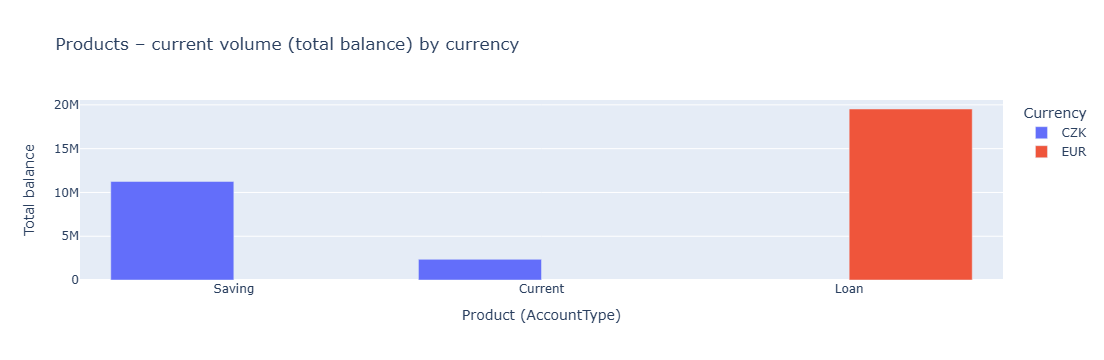

In [11]:
# ============================
# Task (a) – Product overview
# ============================

# 1) pick correct balance column (depends on earlier cleaning)
bal_col = next((c for c in ["BalanceAmount", "Balance"] if c in accounts.columns), None)
if bal_col is None:
    raise ValueError("Cannot find BalanceAmount/Balance in `accounts` dataframe.")

# 2) basic cleanup for grouping
a = accounts.copy()

a["AccountType"] = (
    a.get("AccountType", pd.Series([pd.NA] * len(a)))
     .astype("string")
     .str.strip()
     .fillna("Unknown")
)

a["BalanceCurrency"] = (
    a.get("BalanceCurrency", pd.Series([pd.NA] * len(a)))
     .astype("string")
     .str.strip()
     .str.upper()
     .fillna("UNK")
)

a[bal_col] = pd.to_numeric(a[bal_col], errors="coerce")

# 3) overview by product (split by currency)
product_overview = (
    a.groupby(["AccountType", "BalanceCurrency"], dropna=False)
     .agg(
         accounts_count=("AccountID", "nunique"),
         total_balance=(bal_col, "sum"),
         avg_balance=(bal_col, "mean"),
         min_balance=(bal_col, "min"),
         max_balance=(bal_col, "max"),
     )
     .reset_index()
)

# 4) add shares within each currency (case-study friendly)
product_overview["share_of_accounts_%"] = (
    product_overview["accounts_count"]
    / product_overview.groupby("BalanceCurrency")["accounts_count"].transform("sum")
    * 100
)

product_overview["share_of_balance_%"] = (
    product_overview["total_balance"]
    / product_overview.groupby("BalanceCurrency")["total_balance"].transform("sum")
    * 100
)

# 5) formatting + sorting
for c in ["total_balance", "avg_balance", "min_balance", "max_balance"]:
    product_overview[c] = pd.to_numeric(product_overview[c], errors="coerce").round(2)

product_overview["share_of_accounts_%"] = product_overview["share_of_accounts_%"].round(2)
product_overview["share_of_balance_%"] = product_overview["share_of_balance_%"].round(2)

product_overview = (
    product_overview
    .rename(columns={"BalanceCurrency": "Currency"})
    .sort_values(["Currency", "total_balance"], ascending=[True, False])
    .reset_index(drop=True)
)

display(product_overview)
print("Rows:", product_overview.shape[0])

# 6) Plotly – total balance by product (split by currency)
fig = px.bar(
    product_overview,
    x="AccountType",
    y="total_balance",
    color="Currency",
    barmode="group",
    title="Products – current volume (total balance) by currency",
    hover_data=["accounts_count", "avg_balance", "min_balance", "max_balance", "share_of_balance_%"]
)
fig.update_layout(xaxis_title="Product (AccountType)", yaxis_title="Total balance")
fig.show()

## 5.1) Product volume – number of accounts (visual)

After calculating the portfolio volume in monetary terms, I also visualized the **number of accounts** per product.
This is useful because a product can have:
- many small accounts (high count, lower balance), or
- few large accounts (low count, higher balance).

I keep the view split by currency for consistency with the previous table.


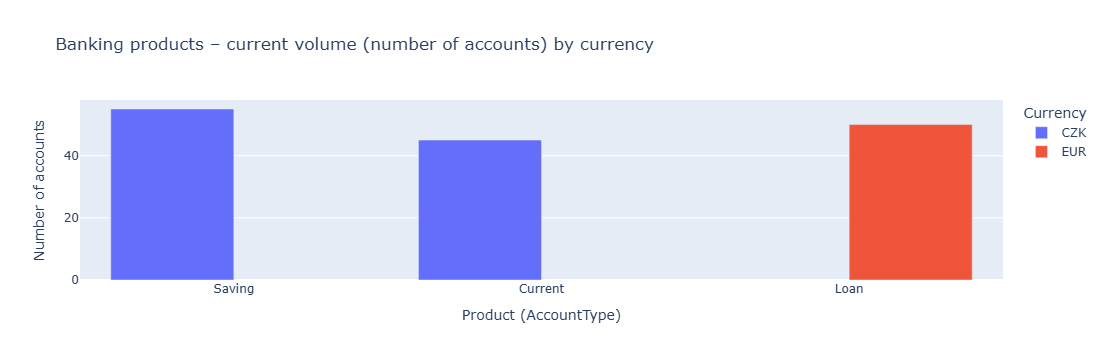

In [12]:
# Plot: number of accounts by product (split by currency)
fig = px.bar(
    product_overview,
    x="AccountType",
    y="accounts_count",
    color="Currency",              # note: product_overview uses "Currency" after rename
    barmode="group",
    title="Banking products – current volume (number of accounts) by currency",
    hover_data=["total_balance", "share_of_accounts_%"]
)
fig.update_layout(xaxis_title="Product (AccountType)", yaxis_title="Number of accounts")
fig.show()

## 5.2) Transaction mix – overview by transaction type

Before moving into product profitability, I created a simple overview of the transaction dataset itself.

I aggregated transactions by `Type` (e.g., Deposit / Withdrawal / Transfer) to understand:
- how many transactions we have per type,
- total monetary volume per type,
- average transaction size per type.

This gives quick intuition about the activity mix in the data.


In [13]:
t = transactions.copy()

# basic cleanup
t["Type"] = (
    t.get("Type", pd.Series([pd.NA] * len(t)))
     .astype("string")
     .str.strip()
     .fillna("Unknown")
)

t["Amount"] = pd.to_numeric(t.get("Amount", pd.Series([pd.NA] * len(t))), errors="coerce")

tx_overview = (
    t.groupby("Type", dropna=False)
     .agg(
         transactions_count=("TransactionID", "nunique"),
         total_amount=("Amount", "sum"),
         avg_amount=("Amount", "mean"),
     )
     .reset_index()
     .sort_values("total_amount", ascending=False)
)

tx_overview["total_amount"] = tx_overview["total_amount"].round(2)
tx_overview["avg_amount"] = tx_overview["avg_amount"].round(2)

display(tx_overview)

,Type,transactions_count,total_amount,avg_amount
1,Deposit,2128,8251384.85,3877.53
2,Transfer,455,667659.44,1467.38
3,Withdrawal,442,665068.80,1504.68
0,Bonus,51,25500.00,500.00


## 5.3) Transaction mix – total amount by type (visual)

Finally, I visualized the total transaction amount per type.  
I add labels above the bars to make the chart readable without hovering.


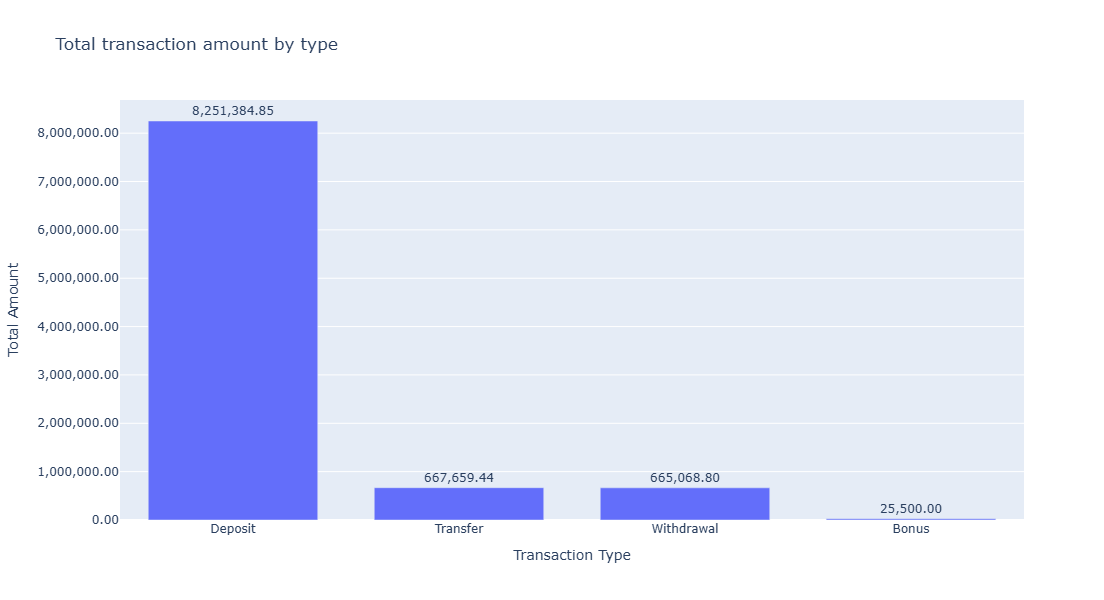

In [14]:
fig = px.bar(
    tx_overview,
    x="Type",
    y="total_amount",
    text="total_amount",
    hover_data={
        "transactions_count": True,
        "avg_amount": True,
        "total_amount": False
    },
    labels={
        "Type": "Transaction Type",
        "total_amount": "Total Amount"
    },
    title="Total transaction amount by type"
)

fig.update_traces(
    texttemplate="%{text:,.2f}",
    textposition="outside"
)

fig.update_layout(
    yaxis_tickformat=",.2f",
    uniformtext_minsize=10,
    uniformtext_mode="hide",
    bargap=0.25,
    height=600
)

fig.show()

### Summary (Task a: Products and current volume)

The dataset contains three banking products identified by `AccountType`: **Saving (55 accounts)**, **Loan (50)**, and **Current (45)**.

To estimate the **current product volume**, I aggregated the **current account balances** by product.

Because balances are recorded in **multiple currencies (CZK/EUR)**, I report totals **separately per currency** to avoid incorrect mixing.

#### CZK products (current volume = total balances)

- **Saving (CZK):** 55 accounts, **CZK 11,254,850.25** total balance  
  - Average balance: **CZK 204,633.64**  
  - Represents **82.67%** of CZK balances (dominant CZK product)

- **Current (CZK):** 45 accounts, **CZK 2,359,397.70** total balance  
  - Average balance: **CZK 52,431.06**  
  - Represents **17.33%** of CZK balances

#### EUR products

- **Loan (EUR):** 50 accounts, **EUR 19,528,838.08** total balance  
  - Average balance: **EUR 390,576.76**  
  - Represents **100%** of EUR balances because it is the only EUR product in the dataset


## 6) Task (b): Count and volume of transactions per product (including inconsistencies)

**Description of the task:**  
Compute the **count** and **volume** of transactions per banking product. The prompt also warns that some transactions may be **inconsistent**, so I need to document how I detect and handle problematic records.

**How I link transactions to products:**  
`transactions.AccountID → accounts.AccountID → accounts.AccountType`

**How I measure “volume”:**
- **Gross volume** = `sum(abs(Amount))`  
  (robust if the dataset does not consistently use signs for inflow/outflow)
- **Net volume** = `sum(Amount)`  
  (direction-sensitive; interpret carefully if sign conventions are unclear)

**Inconsistency approach:**
I apply several transparent flags (missing keys, invalid references, suspicious fees, missing amounts/dates).  
Then I report metrics on:
- **all transactions**
- **clean transactions** (excluding flagged/inconsistent rows)

This gives a business table that is defensible and auditable.


#### Task (b): code + plotly

In [15]:
# ============================
# Task (b) – Step 1: Prepare joined dataset (transactions + product)
# ============================

t = transactions.copy()
a = accounts.copy()

# Ensure key fields exist
for col in ["TransactionID", "AccountID"]:
    if col not in t.columns:
        raise ValueError(f"transactions missing column: {col}")

for col in ["AccountID", "AccountType"]:
    if col not in a.columns:
        raise ValueError(f"accounts missing column: {col}")

# Basic cleanup
t["Type"] = (
    t.get("Type", pd.Series([pd.NA] * len(t)))
     .astype("string")
     .str.strip()
     .fillna("Unknown")
)

# Make sure amount/fee are numeric (safe)
t["Amount"] = pd.to_numeric(t.get("Amount", pd.Series([pd.NA] * len(t))), errors="coerce")
t["Fee"] = pd.to_numeric(t.get("Fee", pd.Series([pd.NA] * len(t))), errors="coerce")

# If Date exists, parse it
if "Date" in t.columns:
    t["Date"] = pd.to_datetime(t["Date"], errors="coerce")

# Join to assign product + currency (if available)
join_cols = ["AccountID", "AccountType"]
if "BalanceCurrency" in a.columns:
    join_cols.append("BalanceCurrency")

tx = t.merge(
    a[join_cols],
    on="AccountID",
    how="left"
)

# Standardize currency naming
if "BalanceCurrency" in tx.columns:
    tx = tx.rename(columns={"BalanceCurrency": "AccountCurrency"})
else:
    tx["AccountCurrency"] = "UNK"

tx["AccountType"] = tx["AccountType"].astype("string").str.strip().fillna("Unknown")
tx["AccountCurrency"] = tx["AccountCurrency"].astype("string").str.strip().str.upper().fillna("UNK")

# Helpful derived column
tx["AbsAmount"] = tx["Amount"].abs()

print("Joined transactions shape:", tx.shape)
display(tx.head(5))

Joined transactions shape: (3076, 9)


,TransactionID,AccountID,Date,Type,Amount,Fee,AccountType,AccountCurrency,AbsAmount
0,1,46.0,2000-01-02 03:32:38,Deposit,1570.02,50,Saving,CZK,1570.02
1,10,2.0,2000-01-25 07:05:26,Deposit,2845.12,50,Saving,CZK,2845.12
2,100,54.0,2000-11-04 06:06:24,Withdrawal,1562.21,100,Current,CZK,1562.21
3,1000,90.0,2008-01-07 10:04:18,Deposit,1389.11,50,Saving,CZK,1389.11
4,1001,110.0,2008-01-12 10:01:00,Transfer,1406.55,0,Current,CZK,1406.55


### 6.1) Data-quality checks: “What does inconsistent mean here?”

In this case study, *inconsistent* means “a record that is likely wrong or unreliable for aggregation.”

I flag issues in three categories:

1. **Key integrity**  
   - missing TransactionID / AccountID  
   - duplicate TransactionID  
   - AccountID does not exist in accounts (cannot assign product)

2. **Amount and fee sanity**  
   - missing amount  
   - zero amount (optional warning; depends on domain)  
   - negative fees  
   - fees greater than absolute transaction amount (strong anomaly)

3. **Date quality** (if the Date column exists)  
   - missing / invalid date

After creating the flags, I create a single column `is_inconsistent` as “any flag = True”.


In [16]:
# ============================
# Task (b) – Step 2: Flag inconsistencies (transparent rules)
# ============================

# --- key integrity
tx["flag_missing_transaction_id"] = tx["TransactionID"].isna()
tx["flag_missing_account_id"] = tx["AccountID"].isna()

# account reference check (after merge: AccountType missing means no match to accounts)
# note: we treat Unknown as a value; we need to detect true "not found"
# easiest approach: if AccountID present but merged AccountType is NA before fill
# we can re-check by merging indicator if you want, but here we approximate:
tx["flag_account_not_found"] = tx["AccountID"].notna() & (tx["AccountType"].isna())

# duplicates: TransactionID repeated
tx["flag_duplicate_transaction_id"] = tx["TransactionID"].notna() & tx.duplicated(subset=["TransactionID"], keep=False)

# --- amount quality
tx["flag_amount_missing"] = tx["Amount"].isna()
tx["flag_amount_zero"] = tx["Amount"].fillna(0).eq(0)

# --- fee quality
tx["flag_fee_negative"] = tx["Fee"].notna() & (tx["Fee"] < 0)
tx["flag_fee_gt_amount"] = tx["Fee"].notna() & tx["Amount"].notna() & (tx["Fee"] > tx["AbsAmount"])

# --- date quality
if "Date" in tx.columns:
    tx["flag_date_missing"] = tx["Date"].isna()
else:
    tx["flag_date_missing"] = False

# final inconsistency flag
flag_cols = [c for c in tx.columns if c.startswith("flag_")]
tx["is_inconsistent"] = tx[flag_cols].any(axis=1)

# Summarize issue counts
issue_summary = (
    tx[flag_cols]
    .sum()
    .sort_values(ascending=False)
    .rename("rows_flagged")
    .reset_index()
    .rename(columns={"index": "issue"})
)

display(issue_summary)

print("Total transactions:", len(tx))
print("Inconsistent transactions:", int(tx["is_inconsistent"].sum()))
print("Clean transactions:", int((~tx["is_inconsistent"]).sum()))

,issue,rows_flagged
0,flag_fee_gt_amount,34
1,flag_missing_transaction_id,0
2,flag_missing_account_id,0
3,flag_account_not_found,0
4,flag_duplicate_transaction_id,0
5,flag_amount_missing,0
6,flag_amount_zero,0
7,flag_fee_negative,0
8,flag_date_missing,0


Total transactions: 3076
Inconsistent transactions: 34
Clean transactions: 3042


### 6.2) Fee anomaly deep-dive (why “inconsistent” matters)

Because transaction fees can directly impact downstream metrics (especially profitability), I added a focused quality check on **fee anomalies**.

I use two related rules:

1. **Fee > abs(Amount)**  
   A fee larger than the transaction itself is usually not realistic in retail banking and often indicates data issues.

2. **Fee ≥ 2 × abs(Amount)**  
   A stricter rule that highlights *extreme* cases (fee is at least double the transaction value).

For transparency, I report:
- how many rows are flagged,
- what share of all transactions they represent,
- and how much volume / fees these flagged rows contribute.



In [17]:
# ============================
# Fee anomaly deep-dive
# ============================

# Safety: avoid division by zero when AbsAmount == 0
tx["fee_ratio"] = np.where(tx["AbsAmount"].fillna(0).eq(0), np.nan, tx["Fee"] / tx["AbsAmount"])

# Rule A: Fee > abs(Amount)
bad_a = tx[tx["flag_fee_gt_amount"]].copy()
print("Rule A (Fee > abs(Amount))")
print("Flagged transactions:", len(bad_a))
print("Share of all transactions (%):", round(len(bad_a) / len(tx) * 100, 2))
print("Gross volume flagged:", round(bad_a["AbsAmount"].sum(), 2))
print("Total fee flagged:", round(bad_a["Fee"].sum(), 2))
print()

# Rule B: Fee >= 2x abs(Amount)
tx["flag_fee_ratio_ge_2"] = tx["fee_ratio"].notna() & (tx["fee_ratio"] >= 2)
bad_b = tx[tx["flag_fee_ratio_ge_2"]].copy()
print("Rule B (Fee >= 2x abs(Amount))")
print("Flagged transactions:", len(bad_b))
print("Share of all transactions (%):", round(len(bad_b) / len(tx) * 100, 2))
print("Gross volume flagged:", round(bad_b["AbsAmount"].sum(), 2))
print("Total fee flagged:", round(bad_b["Fee"].sum(), 2))

# Quick counts in one line (useful during debugging)
display(tx[["flag_fee_gt_amount", "flag_fee_ratio_ge_2"]].sum().rename("flagged_rows"))

# Compact data quality table (computed from actual data, not hard-coded)
dq = pd.DataFrame({
    "rule": ["Fee > abs(Amount)", "Fee >= 2x abs(Amount)"],
    "flagged_rows": [int(tx["flag_fee_gt_amount"].sum()), int(tx["flag_fee_ratio_ge_2"].sum())],
})

dq["share_of_all_%"] = (dq["flagged_rows"] / len(tx) * 100).round(2)
display(dq)

Rule A (Fee > abs(Amount))
Flagged transactions: 34
Share of all transactions (%): 1.11
Gross volume flagged: 1530.13
Total fee flagged: 2350

Rule B (Fee >= 2x abs(Amount))
Flagged transactions: 7
Share of all transactions (%): 0.23
Gross volume flagged: 220.06
Total fee flagged: 600


flag_fee_gt_amount     34
flag_fee_ratio_ge_2     7
Name: flagged_rows, dtype: int64

,rule,flagged_rows,share_of_all_%
0,Fee > abs(Amount),34,1.11
1,Fee >= 2x abs(Amount),7,0.23


In [18]:

# Show a few inconsistent examples (for narrative / audit trail)
cols_to_show = ["TransactionID", "AccountID", "AccountType", "AccountCurrency"]
if "Date" in tx.columns:
    cols_to_show.append("Date")
cols_to_show += ["Type", "Amount", "Fee"]

display(
    tx.loc[tx["is_inconsistent"], cols_to_show]
      .head(15)
)

,TransactionID,AccountID,AccountType,AccountCurrency,Date,Type,Amount,Fee
16,1012,91.0,Saving,CZK,2008-02-04 14:01:43,Deposit,48.56,50
88,1078,113.0,Saving,CZK,2008-09-08 07:17:21,Deposit,34.53,50
150,1133,136.0,Saving,CZK,2009-03-05 15:31:39,Deposit,45.47,50
291,1260,66.0,Saving,CZK,2010-03-02 12:28:30,Deposit,38.10,50
310,1278,78.0,Saving,CZK,2010-04-05 15:42:18,Deposit,40.71,50
321,1288,144.0,Current,CZK,2010-04-24 02:33:49,Withdrawal,15.85,100
444,1399,24.0,Saving,CZK,2011-02-26 08:09:55,Deposit,40.05,50
563,1505,139.0,Current,CZK,2012-01-23 05:47:42,Withdrawal,77.40,100
707,1635,63.0,Current,CZK,2013-02-06 05:14:31,Withdrawal,61.47,100
833,1749,84.0,Current,CZK,2014-02-01 12:17:07,Withdrawal,46.90,100


### 6.3) Metrics: transaction count and volume per product (ALL vs CLEAN)

Now I compute the required deliverable.

I produce two versions:
- **All transactions** (raw totals)
- **Clean transactions** (excluding inconsistent records)

Grouping dimensions:
- `AccountType` (product)
- `AccountCurrency` (keep currencies separate)

Output metrics:
- number of transactions
- gross volume (sum of abs amount)
- net volume (sum of amount)
- average abs amount
- total fees


In [19]:
# ============================
# Task (b) – Step 3: Metrics tables (ALL vs CLEAN)
# ============================

def product_metrics(df_in: pd.DataFrame, label: str) -> pd.DataFrame:
    out = (
        df_in.groupby(["AccountType", "AccountCurrency"], dropna=False)
            .agg(
                transactions_count=("TransactionID", "nunique"),
                gross_volume=("AbsAmount", "sum"),   # safest: money moved
                net_volume=("Amount", "sum"),        # directional (use with caution)
                avg_abs_amount=("AbsAmount", "mean"),
                total_fee=("Fee", "sum"),
            )
            .reset_index()
    )
    out["dataset"] = label

    # safe numeric + rounding
    for c in ["gross_volume", "net_volume", "avg_abs_amount", "total_fee"]:
        out[c] = pd.to_numeric(out[c], errors="coerce").round(2)

    return out

metrics_all = product_metrics(tx, "all_transactions")
metrics_clean = product_metrics(tx.loc[~tx["is_inconsistent"]].copy(), "clean_transactions")

metrics = (
    pd.concat([metrics_all, metrics_clean], ignore_index=True)
      .sort_values(["dataset", "AccountCurrency", "gross_volume"], ascending=[True, True, False])
      .reset_index(drop=True)
)

display(metrics)

,AccountType,AccountCurrency,transactions_count,gross_volume,net_volume,avg_abs_amount,total_fee,dataset
0,Saving,CZK,1716,7605370.68,7605370.68,4432.03,83250,all_transactions
1,Current,CZK,1360,2004242.41,2004242.41,1473.71,46515,all_transactions
2,Saving,CZK,1695,7604609.53,7604609.53,4486.50,82200,clean_transactions
3,Current,CZK,1347,2003473.43,2003473.43,1487.36,45215,clean_transactions


### 6.4) Visuals: transaction count and volume per product (clean view)

For presentation, I use the **clean transactions** version:
- Chart 1: number of transactions per product
- Chart 2: gross volume per product

Both charts are split by currency (no FX assumptions).


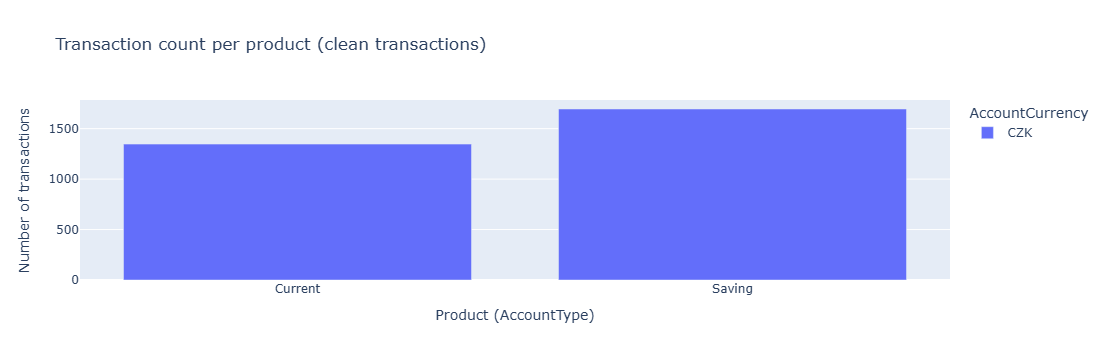

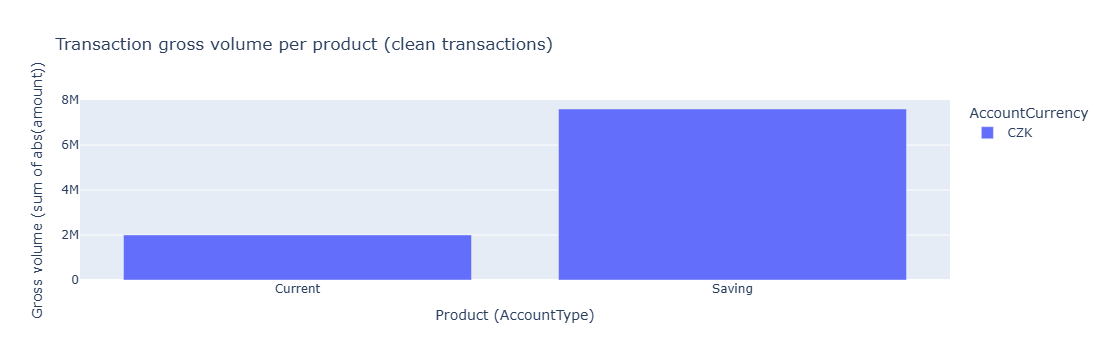

In [20]:
# ============================
# Task (b) – Step 4: Plotly charts (clean transactions)
# ============================

plot_df = metrics_clean.copy()

# A) Transaction count per product (clean)
fig1 = px.bar(
    plot_df,
    x="AccountType",
    y="transactions_count",
    color="AccountCurrency",
    barmode="group",
    title="Transaction count per product (clean transactions)",
    hover_data=["gross_volume", "net_volume", "total_fee", "avg_abs_amount"]
)
fig1.update_layout(xaxis_title="Product (AccountType)", yaxis_title="Number of transactions")
fig1.show()

# B) Gross volume per product (clean)
fig2 = px.bar(
    plot_df,
    x="AccountType",
    y="gross_volume",
    color="AccountCurrency",
    barmode="group",
    title="Transaction gross volume per product (clean transactions)",
    hover_data=["transactions_count", "net_volume", "total_fee", "avg_abs_amount"]
)
fig2.update_layout(xaxis_title="Product (AccountType)", yaxis_title="Gross volume (sum of abs(amount))")
fig2.show()

### Conclusion (Task b: Count and volume of transactions per product, including inconsistencies)

#### What I produced
I linked each transaction to a product using:
`transactions.AccountID → accounts.AccountID → accounts.AccountType`  
and then calculated transaction **count** and **volume** per product.

To make volume robust, I reported:
- **Gross volume** = sum of `abs(Amount)` (recommended if sign conventions may vary)
- **Net volume** = sum of `Amount` (direction-sensitive)

#### Data quality / inconsistencies
Out of **3,076** total transactions, **34** were flagged as inconsistent (**1.11%**) using the rule:

- **Fee > abs(Amount)**

No other issues were detected (no missing IDs, duplicates, missing amounts, negative fees, missing dates).

A stricter check identified **7 extreme cases** (**0.23%**) where:
- **Fee ≥ 2 × abs(Amount)**

**Impact of flagged rows**
- Flagged transactions represent only **1.11%** of rows, and their monetary scale is small:
  - Gross volume flagged: **1,530.13**
  - Total fee flagged: **2,350.00**
This suggests the dataset is mostly consistent, but fee anomalies exist and should be excluded from “clean” aggregates.

#### Results: transaction count & volume per product (CZK)
All transactions are in **CZK** for the products that appear in the transaction table (Current and Saving).

**All transactions**
- **Saving (CZK):** 1,716 transactions  
  - Gross volume: **7,605,370.68**  
  - Total fees: **83,250.00**  
  - Avg transaction size (abs): **4,432.03**
- **Current (CZK):** 1,360 transactions  
  - Gross volume: **2,004,242.41**  
  - Total fees: **46,515.00**  
  - Avg transaction size (abs): **1,473.71**

**Clean transactions (excluding inconsistent fee rows)**
- **Saving (CZK):** 1,695 transactions  
  - Gross volume: **7,604,609.53**  
  - Total fees: **82,200.00**  
  - Avg transaction size (abs): **4,486.50**
- **Current (CZK):** 1,347 transactions  
  - Gross volume: **2,003,473.43**  
  - Total fees: **45,215.00**  
  - Avg transaction size (abs): **1,487.36**

#### Interpretation
- **Savings accounts drive the majority of transaction activity and volume** (roughly ~3.8x the gross volume of Current accounts in CZK), indicating higher customer movement and/or larger typical transaction sizes in Saving products.
- **Fee anomalies are rare and low-volume**, but they materially affect fee totals (and later profitability work), so separating **all vs clean** results is a sensible and defensible approach.


## 7) Bonus: Costs & revenues per product for 2023 + profitability

**Goal:** show **revenues**, **costs**, and **profitability** per product for the last year (**2023**).

### What I did

Because the dataset does not contain daily balances or an interest accrual ledger, I used a **simple, transparent approximation**:

**Interest approximation (Loans and Savings):**
- `InterestAmount ≈ Balance × APR × ActiveFraction(2023)`
- `Balance` is used as a proxy for average balance (no daily history available)
- If `DateOpened` exists and is after 2023-01-01, I pro-rate activity to 2023 (ActiveFraction)

**Fee revenue (Current and Savings):**
- Fee revenue is calculated from transactions in 2023: `sum(Fee)`
- To protect the result, I exclude **inconsistent fee rows** from “clean” fee revenue:
  - **Fee > abs(Amount)** (fee bigger than the transaction itself)

**Outputs delivered**
- A P&L table per product & currency:
  - balances, interest revenue/cost, fee revenue (all vs clean), total revenue, total cost, profit
  - profitability KPIs: profit margin and profit on balance
- Supporting tables:
  - data quality counts for 2023
  - list of flagged 2023 transactions (audit trail)
  - profit per account
  - compact executive summary table
- Plotly charts:
  - profit by product
  - revenue/cost component breakdown

**Important note:** currencies are kept separate (CZK/EUR). No FX conversion is assumed.


In [21]:
YEAR = 2023

# ----------------------------
# 0) Preconditions
# ----------------------------
if "accounts" not in globals() or "transactions" not in globals():
    raise NameError("I need dataframes named `accounts` and `transactions` (from previous steps).")

# ----------------------------
# 1) Prepare ACCOUNTS (balances + APR + active fraction)
# ----------------------------
a = accounts.copy()

# pick correct balance column (depends on earlier cleaning)
bal_col = next((c for c in ["BalanceAmount", "Balance"] if c in a.columns), None)
if bal_col is None:
    raise ValueError("accounts must contain BalanceAmount or Balance.")

# required columns
for col in ["AccountID", "AccountType"]:
    if col not in a.columns:
        raise ValueError(f"accounts missing column: {col}")

# currency column (fallback)
if "BalanceCurrency" not in a.columns:
    a["BalanceCurrency"] = "UNK"

# clean types
a["AccountType"] = a["AccountType"].astype("string").str.strip().fillna("Unknown")
a["BalanceCurrency"] = a["BalanceCurrency"].astype("string").str.strip().str.upper().fillna("UNK")

# numeric balance / apr
a[bal_col] = pd.to_numeric(a[bal_col], errors="coerce").fillna(0.0)
if "APR" not in a.columns:
    a["APR"] = 0.0
a["APR"] = pd.to_numeric(a["APR"], errors="coerce").fillna(0.0)

# dates for optional pro-rating
start = pd.Timestamp(f"{YEAR}-01-01")
end   = pd.Timestamp(f"{YEAR}-12-31")
days_in_year = 366 if pd.Timestamp(f"{YEAR}-12-31").is_leap_year else 365

if "DateOpened" in a.columns:
    a["DateOpened"] = pd.to_datetime(a["DateOpened"], errors="coerce")
else:
    a["DateOpened"] = pd.NaT

# active fraction inside YEAR (simple pro-rating)
opened = a["DateOpened"]
active_start = opened.where(opened.notna() & (opened > start), start)
active_end = pd.Series([end] * len(a), index=a.index)

days_active = (active_end - active_start).dt.days + 1
days_active = days_active.clip(lower=0, upper=days_in_year).fillna(days_in_year)
a["active_fraction"] = (days_active / float(days_in_year)).astype(float)

# interest model (approx)
a["interest_amount"] = a[bal_col] * a["APR"] * a["active_fraction"]

is_loan = a["AccountType"].str.lower().eq("loan")
is_saving = a["AccountType"].str.lower().eq("saving")

# Bank earns on loans, pays on savings
a["interest_revenue"] = np.where(is_loan, a["interest_amount"], 0.0)
a["interest_cost"] = np.where(is_saving, a["interest_amount"], 0.0)

interest_2023 = (
    a.groupby(["AccountType", "BalanceCurrency"], dropna=False)
     .agg(
         accounts_count=("AccountID", "nunique"),
         total_balance=(bal_col, "sum"),
         interest_revenue=("interest_revenue", "sum"),
         interest_cost=("interest_cost", "sum"),
     )
     .reset_index()
     .rename(columns={"BalanceCurrency": "Currency"})
)

# numeric safety
for c in ["accounts_count", "total_balance", "interest_revenue", "interest_cost"]:
    interest_2023[c] = pd.to_numeric(interest_2023[c], errors="coerce").fillna(0)
interest_2023["accounts_count"] = interest_2023["accounts_count"].astype(int)

In [22]:
# ----------------------------
# 2) Prepare TRANSACTIONS (2023 only) + assign product
# ----------------------------
t = transactions.copy()
if "Date" not in t.columns:
    raise ValueError("transactions must contain Date column.")

t["Date"] = pd.to_datetime(t["Date"], errors="coerce")
t = t[(t["Date"].notna()) & (t["Date"] >= start) & (t["Date"] <= end)].copy()

t["Amount"] = pd.to_numeric(t.get("Amount"), errors="coerce")
t["Fee"] = pd.to_numeric(t.get("Fee"), errors="coerce")
t["AbsAmount"] = t["Amount"].abs()

tx = t.merge(
    a[["AccountID", "AccountType", "BalanceCurrency"]],
    on="AccountID",
    how="left"
).rename(columns={"BalanceCurrency": "Currency"})

tx["AccountType"] = tx["AccountType"].astype("string").str.strip().fillna("Unknown")
tx["Currency"] = tx["Currency"].astype("string").str.strip().str.upper().fillna("UNK")

# inconsistency rule for fees
tx["flag_fee_gt_amount"] = tx["Fee"].notna() & tx["AbsAmount"].notna() & (tx["Fee"] > tx["AbsAmount"])

# fees apply to Current + Saving (as per prompt)
fee_products = tx["AccountType"].str.lower().isin(["current", "saving"])

fees_all_2023 = (
    tx[fee_products]
    .groupby(["AccountType", "Currency"], dropna=False)
    .agg(
        fee_revenue=("Fee", "sum"),
        transactions_count=("TransactionID", "nunique"),
    )
    .reset_index()
)

fees_clean_2023 = (
    tx[fee_products & (~tx["flag_fee_gt_amount"])]
    .groupby(["AccountType", "Currency"], dropna=False)
    .agg(
        fee_revenue_clean=("Fee", "sum"),
        transactions_count_clean=("TransactionID", "nunique"),
    )
    .reset_index()
)

flags_2023 = (
    tx[fee_products]
    .groupby(["AccountType", "Currency"], dropna=False)
    .agg(flagged_fee_gt_amount=("flag_fee_gt_amount", "sum"))
    .reset_index()
)

# numeric safety
for df_ in [fees_all_2023, fees_clean_2023, flags_2023]:
    for c in df_.columns:
        if c in ["fee_revenue", "fee_revenue_clean"]:
            df_[c] = pd.to_numeric(df_[c], errors="coerce").fillna(0.0)
        if c in ["transactions_count", "transactions_count_clean", "flagged_fee_gt_amount"]:
            df_[c] = pd.to_numeric(df_[c], errors="coerce").fillna(0).astype(int)

In [23]:
# ----------------------------
# 3) Combine into Product P&L for 2023 (per product, per currency)
# ----------------------------
pnl_2023 = interest_2023.merge(fees_all_2023, on=["AccountType", "Currency"], how="left")
pnl_2023 = pnl_2023.merge(fees_clean_2023, on=["AccountType", "Currency"], how="left")
pnl_2023 = pnl_2023.merge(flags_2023, on=["AccountType", "Currency"], how="left")

# fill NaNs (Loan has no fee metrics)
for c in ["fee_revenue", "fee_revenue_clean"]:
    pnl_2023[c] = pd.to_numeric(pnl_2023.get(c), errors="coerce").fillna(0.0)

for c in ["transactions_count", "transactions_count_clean", "flagged_fee_gt_amount"]:
    pnl_2023[c] = pd.to_numeric(pnl_2023.get(c), errors="coerce").fillna(0).astype(int)

# totals
pnl_2023["total_revenue_clean"] = pnl_2023["interest_revenue"] + pnl_2023["fee_revenue_clean"]
pnl_2023["total_cost"] = pnl_2023["interest_cost"]
pnl_2023["profit_clean"] = pnl_2023["total_revenue_clean"] - pnl_2023["total_cost"]

# profitability KPIs
pnl_2023["profit_margin_%"] = np.where(
    pnl_2023["total_revenue_clean"] > 0,
    (pnl_2023["profit_clean"] / pnl_2023["total_revenue_clean"]) * 100,
    np.nan
)

pnl_2023["profit_on_balance_%"] = np.where(
    pnl_2023["total_balance"] > 0,
    (pnl_2023["profit_clean"] / pnl_2023["total_balance"]) * 100,
    np.nan
)

# rounding for presentation
round_2 = [
    "total_balance", "interest_revenue", "interest_cost",
    "fee_revenue", "fee_revenue_clean",
    "total_revenue_clean", "total_cost", "profit_clean"
]
for c in round_2:
    pnl_2023[c] = pd.to_numeric(pnl_2023[c], errors="coerce").fillna(0.0).astype(float).round(2)

pnl_2023["profit_margin_%"] = pd.to_numeric(pnl_2023["profit_margin_%"], errors="coerce").round(2)
pnl_2023["profit_on_balance_%"] = pd.to_numeric(pnl_2023["profit_on_balance_%"], errors="coerce").round(4)

pnl_2023 = pnl_2023.sort_values(["Currency", "profit_clean"], ascending=[True, False]).reset_index(drop=True)

print(f"=== Product P&L for {YEAR} (per currency) ===")
display(pnl_2023)

=== Product P&L for 2023 (per currency) ===


,AccountType,Currency,accounts_count,total_balance,interest_revenue,interest_cost,fee_revenue,transactions_count,fee_revenue_clean,transactions_count_clean,flagged_fee_gt_amount,total_revenue_clean,total_cost,profit_clean,profit_margin_%,profit_on_balance_%
0,Current,CZK,45,2359397.70,0.00,0.00,2185.0,56,2185.0,56,0,2185.00,0.00,2185.00,100.00,0.0926
1,Saving,CZK,55,11254850.25,0.00,318885.59,3900.0,129,3850.0,128,1,3850.00,318885.59,-315035.59,-8182.74,-2.7991
2,Loan,EUR,50,19528838.08,1705093.82,0.00,0.0,0,0.0,0,0,1705093.82,0.00,1705093.82,100.00,8.7312


In [24]:
# ----------------------------
# 4) Supporting outputs (audit trail + summary tables)
# ----------------------------

# 4A) data quality counts for 2023
dq_2023 = pd.DataFrame({
    "metric": ["transactions_2023_total", "transactions_2023_fee_products", "flag_fee_gt_amount_rows"],
    "value": [len(t), int(fee_products.sum()), int(tx.loc[fee_products, "flag_fee_gt_amount"].sum())]
})
display(dq_2023)

,metric,value
0,transactions_2023_total,185
1,transactions_2023_fee_products,185
2,flag_fee_gt_amount_rows,1


In [25]:
# 4B) transposed view (sometimes useful for presenting)
pnl_2023_T = pnl_2023.T
display(pnl_2023_T)

,0,1,2
AccountType,Current,Saving,Loan
Currency,CZK,CZK,EUR
accounts_count,45,55,50
total_balance,2359397.7,11254850.25,19528838.08
interest_revenue,0.0,0.0,1705093.82
interest_cost,0.0,318885.59,0.0
fee_revenue,2185.0,3900.0,0.0
transactions_count,56,129,0
fee_revenue_clean,2185.0,3850.0,0.0
transactions_count_clean,56,128,0


In [26]:
# 4C) show flagged transaction(s) in 2023 (if any)
bad_2023 = tx[tx["flag_fee_gt_amount"]].copy()
print("Flagged transactions in 2023:", len(bad_2023))
if len(bad_2023):
    display(
        bad_2023[["TransactionID", "AccountID", "AccountType", "Currency", "Date", "Type", "Amount", "Fee", "AbsAmount"]]
        .sort_values("Fee", ascending=False)
    )

Flagged transactions in 2023: 1


,TransactionID,AccountID,AccountType,Currency,Date,Type,Amount,Fee,AbsAmount
179,3071,7.0,Saving,CZK,2023-11-27 14:02:48,Deposit,44.5,50,44.5


In [27]:
# 4D) profit per account (nice KPI for business readers)
pnl_2023["profit_per_account"] = (pnl_2023["profit_clean"] / pnl_2023["accounts_count"]).round(2)
display(pnl_2023[["AccountType", "Currency", "profit_clean", "profit_on_balance_%", "profit_per_account"]])

# 4E) compact executive summary
summary = pnl_2023[[
    "AccountType", "Currency", "accounts_count",
    "total_revenue_clean", "total_cost", "profit_clean", "profit_on_balance_%"
]].copy()

summary = summary.sort_values(["Currency", "profit_clean"], ascending=[True, False]).reset_index(drop=True)
display(summary)

,AccountType,Currency,profit_clean,profit_on_balance_%,profit_per_account
0,Current,CZK,2185.00,0.0926,48.56
1,Saving,CZK,-315035.59,-2.7991,-5727.92
2,Loan,EUR,1705093.82,8.7312,34101.88


,AccountType,Currency,accounts_count,total_revenue_clean,total_cost,profit_clean,profit_on_balance_%
0,Current,CZK,45,2185.00,0.00,2185.00,0.0926
1,Saving,CZK,55,3850.00,318885.59,-315035.59,-2.7991
2,Loan,EUR,50,1705093.82,0.00,1705093.82,8.7312


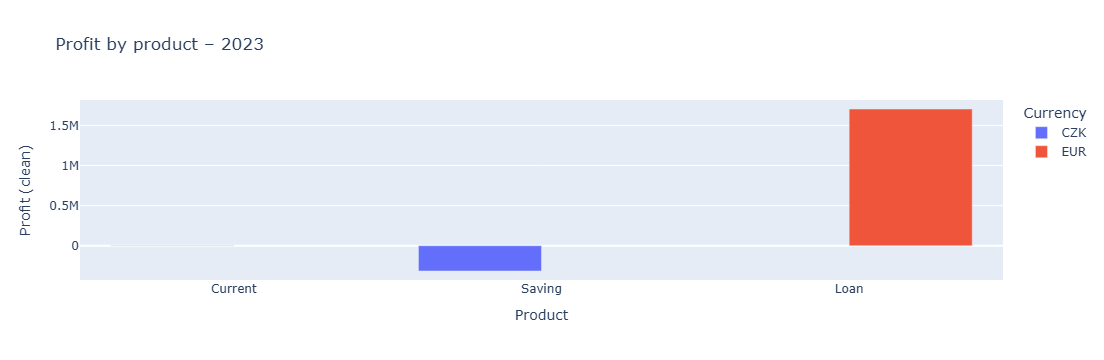

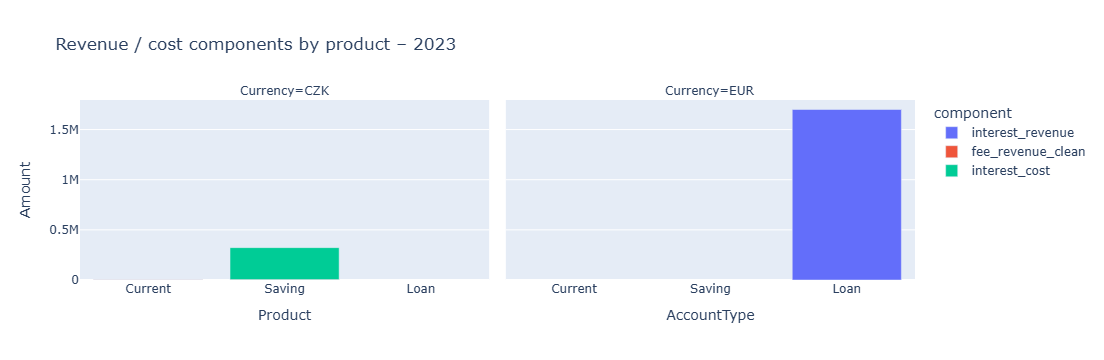

In [28]:
# ----------------------------
# 5) Plotly charts
# ----------------------------

# A) Profit per product
fig_profit = px.bar(
    pnl_2023,
    x="AccountType",
    y="profit_clean",
    color="Currency",
    barmode="group",
    title=f"Profit by product – {YEAR}",
    hover_data=["accounts_count", "total_balance", "total_revenue_clean", "total_cost", "profit_on_balance_%", "profit_per_account"]
)
fig_profit.update_layout(xaxis_title="Product", yaxis_title="Profit (clean)")
fig_profit.show()

# B) Components (interest revenue, fee revenue, interest cost)
pnl_components = pnl_2023.melt(
    id_vars=["AccountType", "Currency"],
    value_vars=["interest_revenue", "fee_revenue_clean", "interest_cost"],
    var_name="component",
    value_name="value"
)

fig_components = px.bar(
    pnl_components,
    x="AccountType",
    y="value",
    color="component",
    facet_col="Currency",
    barmode="relative",
    title=f"Revenue / cost components by product – {YEAR}"
)
fig_components.update_layout(xaxis_title="Product", yaxis_title="Amount")
fig_components.show()

### Conclusion (2023 profitability by product)

Using the available account balances, APR values, and 2023 transaction fees, I estimated **revenues, costs, and profitability per product** (reported **separately by currency**).

#### Key findings

**1) Current accounts (CZK) – small positive profit driven by fees**
- 45 accounts, CZK 2,359,397.70 total balance  
- Revenue comes only from transaction fees (clean fee revenue: CZK 2,185.00)  
- Total cost in this simplified model is CZK 0.00 (no interest cost applied to Current)  
- **Profit (clean): CZK 2,185.00**  
- Profit on balance: **0.0926%** (very low margin, fee-based product)

**2) Savings accounts (CZK) – negative profitability driven by interest cost**
- 55 accounts, CZK 11,254,850.25 total balance  
- Fee revenue is small (clean fee revenue: CZK 3,850.00)  
- Interest cost (paid to customers) dominates: CZK 318,885.59  
- **Profit (clean): –CZK 315,035.59**  
- Profit on balance: **–2.7991%**  
- This result indicates that, under the model assumptions, savings are a **loss-making product** in CZK because the interest expense is not offset by fee income.

**3) Loans (EUR) – highly profitable due to interest revenue**
- 50 accounts, EUR 19,528,838.08 total balance  
- Interest revenue estimate: EUR 1,705,093.82  
- No fee revenue was observed for loans in the provided fee model (fees assumed only for Current and Savings)  
- **Profit (clean): EUR 1,705,093.82**  
- Profit on balance: **8.7312%** (strong interest-driven profitability)

#### Data-quality note (fees)

I identified **one inconsistent transaction fee** in 2023 for Savings (CZK), where the fee is higher than the transaction amount:

- TransactionID 3071 (2023-11-27): Amount CZK 44.50, Fee CZK 50.00

This row was excluded from the **clean fee revenue** calculation for Savings. The overall impact is small (1 flagged row), but documenting and handling it improves credibility of the results.

#### Interpretation caveat

This P&L is based on a simplified interest approximation (`Balance × APR × active_fraction`) due to the lack of daily balance history and accrual rules.  
However, the directional insight is still useful:
- **Loans generate material interest revenue**,  
- **Savings can be costly if APR is high relative to fee income**,  
- **Current accounts behave as low-margin, fee-driven products**.


## 8) Final Conclusion

### What I delivered
- A robust loader for a messy CSV export and a reproducible cleaning workflow (encoding/delimiter tolerance, type-safe parsing).
- Normalized entity tables (**Customers, Accounts, Branches, Employees, Transactions**) and a clear PK/FK logical model.
- Product portfolio overview by currency (account counts + total/avg/min/max balances; no mixing of CZK/EUR).
- Transaction count and volume per product, reported as:
  - **Gross volume** = sum(abs(amount))
  - **Net volume** = sum(amount)
  plus a transparent inconsistency check focused on fee sanity.

### Key findings (from the data)
- Transaction dataset quality is generally good: **34 / 3,076 transactions (1.11%)** were flagged as inconsistent under **Fee > abs(Amount)**.
  - A stricter rule flagged **7 / 3,076 (0.23%)** extreme cases where **Fee ≥ 2× abs(Amount)**.
- In CZK, the **Saving product dominates transaction volume** versus Current (based on gross volume).
- 2023 profitability (per currency, using the stated assumptions):
  - **Current (CZK):** small positive profit driven by fees.
  - **Saving (CZK):** negative profit driven by interest cost outweighing fee income.
  - **Loan (EUR):** strongly positive profit driven by interest revenue.

### Assumptions and limitations (important for interpretation)
Because the dataset does not include daily balance history or an interest accrual ledger:
- Interest was approximated as `Balance × APR × active_fraction_in_2023`.
- Balances were treated as a proxy for “average balance.”
- Fee revenue used transaction fees, with anomalous fee rows excluded from “clean” calculations.
- Results were kept **per currency** (no FX rates were provided).

### Next steps (if required by stakeholders)
- Confirm APR business rules (annual vs daily accrual, compounding, treatment of partial-year balances).
- Confirm whether `Balance` is point-in-time, end-of-period, or average balance.
- Clarify fee semantics (true monetary fee vs coded value / tiered pricing / minimum fee logic).



In [29]:
out_dir = Path("case_study_outputs")
out_dir.mkdir(exist_ok=True)

# ----------------------------
# 1) Save CSV files (as you already do)
# ----------------------------
customers.to_csv(out_dir / "customers.csv", index=False)
branches.to_csv(out_dir / "branches.csv", index=False)
employees.to_csv(out_dir / "employees.csv", index=False)
accounts.to_csv(out_dir / "accounts.csv", index=False)
transactions.to_csv(out_dir / "transactions.csv", index=False)

product_overview.to_csv(out_dir / "product_overview.csv", index=False)
pnl_2023.to_csv(out_dir / "pnl_2023.csv", index=False)

metrics.to_csv(out_dir / "tx_metrics_all_vs_clean.csv", index=False)
issue_summary.to_csv(out_dir / "tx_issue_summary.csv", index=False)

# ----------------------------
# 2) Save individual Excel files (one table = one .xlsx)
# ----------------------------
customers.to_excel(out_dir / "customers.xlsx", index=False)
branches.to_excel(out_dir / "branches.xlsx", index=False)
employees.to_excel(out_dir / "employees.xlsx", index=False)
accounts.to_excel(out_dir / "accounts.xlsx", index=False)
transactions.to_excel(out_dir / "transactions.xlsx", index=False)

product_overview.to_excel(out_dir / "product_overview.xlsx", index=False)
pnl_2023.to_excel(out_dir / "pnl_2023.xlsx", index=False)

metrics.to_excel(out_dir / "tx_metrics_all_vs_clean.xlsx", index=False)
issue_summary.to_excel(out_dir / "tx_issue_summary.xlsx", index=False)

# ----------------------------
# 3) (Recommended) One combined Excel workbook with multiple sheets
# ----------------------------
combined_path = out_dir / "case_study_outputs.xlsx"

with pd.ExcelWriter(combined_path, engine="openpyxl") as writer:
    customers.to_excel(writer, sheet_name="customers", index=False)
    branches.to_excel(writer, sheet_name="branches", index=False)
    employees.to_excel(writer, sheet_name="employees", index=False)
    accounts.to_excel(writer, sheet_name="accounts", index=False)
    transactions.to_excel(writer, sheet_name="transactions", index=False)

    product_overview.to_excel(writer, sheet_name="product_overview", index=False)
    metrics.to_excel(writer, sheet_name="tx_metrics_all_vs_clean", index=False)
    issue_summary.to_excel(writer, sheet_name="tx_issue_summary", index=False)
    pnl_2023.to_excel(writer, sheet_name="pnl_2023", index=False)

#print("Saved CSV + Excel outputs to:", out_dir.resolve())
#print("Combined workbook:", combined_path.resolve())
